# Work-In-Progress connecting an AND-gate and OR-gate (Binary)

[[ 0. -2.  4.  0.  0.]
 [-2.  0.  4.  0.  0.]
 [ 4.  4.  0. -4.  6.]
 [ 0.  0. -4.  0.  6.]
 [ 0.  0.  6.  6.  0.]]
[ 0.  0. -8. -2. -4.]


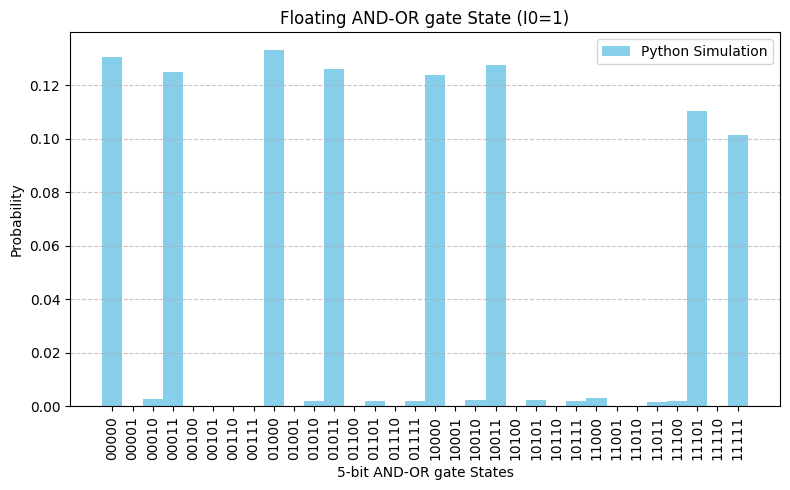

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import os

def compute_energy_binary(m, J, h, I0=1.0):
    """
    Compute the Ising-like energy for a binary state m in {0,1}^N
    using the binary parameters J and h.
    
    The energy is defined as:
        E(m) = -½ * m^T J m - h^T m
    and then scaled by the global factor I0.
    """
    interaction = -0.5 * np.dot(m, J.dot(m))
    bias = -np.dot(h, m)
    return I0 * (interaction + bias)

def boltzmann_distribution_binary(J, h, I0=1.0):
    """
    Enumerate all 2^N binary states, compute their energy,
    and return the normalized Boltzmann probabilities based on exp(-E).
    """
    N = len(h)
    all_states = np.array(list(product([0, 1], repeat=N)))
    energies = np.array([compute_energy_binary(state, J, h, I0) for state in all_states])
    weights = np.exp(-energies)
    return weights / np.sum(weights)

def threshold(x, y):
    """Return 1 if x < y else 0."""
    return 1 if x < y else 0

def simulate_p_bits(num_steps=1000, I0=1.0, use_boltzmann=False,h_bipolar=None):
    """
    Simulate a 5-p-bit AND-OR gate in its floating (invertible) state.
    
    Uses the following bipolar parameters:
        J_bipolar = [[ 0, -1, -1,  1,  2],
                     [-1,  0, -1,  1,  2],
                     [-1, -1,  0,  1,  2],
                     [ 1,  1,  1,  0, -2],
                     [ 2,  2,  2, -2,  0]]
                     
        h_bipolar = [1, 1, 1, -2, -2]
    
    These parameters are converted to the binary domain as follows:
        J_binary = 2 * J_bipolar
        h_binary = h_bipolar - J_bipolar · 1
    where "1" is a vector of ones (length 5).
    """
    # Bipolar parameters for the Full Adder
    J_bipolar = np.array([
        [ 0, -1,  2,  0,  0],
        [-1,  0,  2,  0,  0],
        [ 2,  2,  0, -2,  3],
        [ 0,  0, -2,  0,  3],
        [ 0,  0,  3,  3,  0]
    ])

    # Convert to binary parameters
    J_binary = 2.0 * J_bipolar
    ones_vec = np.ones(5)  # Now 5 p-bits instead of 3
    h_binary = h_bipolar - J_bipolar.dot(ones_vec)
    
    # Use the binary parameters for simulation
    J = J_binary.copy()
    h = h_binary.copy()
    print(J)
    print(h)
    # If using the Boltzmann method, sample directly from the distribution.
    if use_boltzmann:
        all_states = np.array(list(product([0, 1], repeat=5)))
        p = boltzmann_distribution_binary(J, h, I0)
        # Sample num_steps states according to the Boltzmann distribution.
        indices = np.random.choice(len(all_states), num_steps, p=p)
        return all_states[indices]
    
    # Initialize the p-bits randomly (5 bits)
    m = np.random.choice([0, 1], size=5)
    
    # Record the history of states
    m_history = []
    for _ in range(num_steps):
        for i in range(5):  # Update each of the 5 p-bits sequentially.
            # Compute the input to p-bit i.
            I_i = I0 * (h[i] + np.dot(J[i], m))
            # print(np.dot(J[i], m))
            # Determine the activation probability using a shifted and scaled tanh.
            activation_function = (np.tanh(I_i) + 1) / 2
            random_value = np.random.uniform(0, 1)
            m[i] = threshold(random_value, activation_function)
        m_history.append(m.copy())
    
    return np.array(m_history)

def plot_probabilities(num_steps=100000, savefig=False, save_csv=False,h_bipolar=None):
    """
    Plot the probability distributions for the floating state of the 5-p-bit AND-OR gate.
    
    Two distributions are shown:
      - 'Python Simulation': obtained by sequentially updating p-bits.
      - 'Boltzmann': obtained by sampling from the analytical Boltzmann distribution.
    """
    # Enumerate all possible 5-bit states (there are 32)
    all_states = np.array(list(product([0, 1], repeat=5)))
    
    title = 'Floating AND-OR gate State (I0=1)'
    color = 'skyblue'
    
    # Generate simulation results.
    results = simulate_p_bits(num_steps=num_steps, I0=1.0, use_boltzmann=False,h_bipolar=h_bipolar)
    # results_boltzmann = simulate_p_bits(num_steps=num_steps, I0=1.0, use_boltzmann=True,h_bipolar=h_bipolar)
    
    # Compute the frequencies for each unique state from the simulation.
    unique_states, counts = np.unique(results, axis=0, return_counts=True)
    probabilities = counts / np.sum(counts)
    
    # unique_states_b, counts_b = np.unique(results_boltzmann, axis=0, return_counts=True)
    # probabilities_b = counts_b / np.sum(counts_b)
    
    # Initialize dictionaries to hold probabilities for all possible states.
    state_probabilities = {tuple(state): 0 for state in all_states}
    # state_probabilities_b = {tuple(state): 0 for state in all_states}
    
    for state, prob in zip(unique_states, probabilities):
        state_probabilities[tuple(state)] = prob
    # for state, prob in zip(unique_states_b, probabilities_b):
    #     state_probabilities_b[tuple(state)] = prob
        
    # Prepare data for plotting.
    states_str = [''.join(map(str, state)) for state in all_states]
    prob_values = [state_probabilities[tuple(state)] for state in all_states]
    # prob_values_b = [state_probabilities_b[tuple(state)] for state in all_states]
    x = np.arange(len(states_str))
    bar_width = 1
    
    # Create the bar plot.
    plt.figure(figsize=(8, 5))
    plt.bar(x, prob_values, bar_width, color=color, label='Python Simulation')
    # plt.bar(x + bar_width/2, prob_values_b, bar_width, color='black', alpha=0.6, label='Boltzmann')
    plt.xticks(x, states_str, rotation=90)
    plt.title(title)
    plt.xlabel('5-bit AND-OR gate States')
    plt.ylabel('Probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    if savefig:
        os.makedirs("Plots", exist_ok=True)
        filename = f"Plots/AND_OR_PythonSim_{title.replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved plot: {filename}")
    
    plt.show()
    plt.close()
    
    # Optionally, save the results to a CSV file.
    if save_csv:
        all_results = []
        for state_str, p_val, p_val_b in zip(states_str, prob_values):
            all_results.append({
                'state': state_str,
                'normalized_counts_Python': p_val,
                'normalized_counts_Boltzmann': p_val_b
            })
        results_df = pd.DataFrame(all_results)
        results_df.to_csv("AND_OR_Python_Boltzmann.csv", index=False)
        print("Labeled results saved to 'AND_OR_Python_Boltzmann.csv'")

# Run the plot function for the floating Full Adder state.
plot_probabilities(num_steps=10000, savefig=False, save_csv=False,h_bipolar=np.array([1, 1, -3, -1, 2]))